In [1]:
# %% [markdown]
# # HDBSCAN + DTW: Premium Time Series Clustering
# ## Combining Dynamic Time Warping with Density-Based Clustering
# 
# This notebook implements HDBSCAN with DTW distances for maximum accuracy in pattern detection.
# Best for datasets where temporal alignment is critical.

# %% [markdown]
# ## Step 1: Setup and Import Libraries

# %%
# Install required packages (run once)
# !pip install hdbscan dtaidistance numba scikit-learn pandas numpy 

In [2]:
!pip install hdbscan dtaidistance numba scikit-learn pandas numpy matplotlib seaborn tqdm

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/726.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/726.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/726.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/726.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/726.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/726.2 kB ? eta -:--:--
   -------------- ------------------------- 262.1/726.2 kB ? eta -:--:--
   ---------------------------- ----------- 524.3/726.2 kB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 726.2/726.2 kB 1.3 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# DTW and HDBSCAN
from dtaidistance import dtw
from dtaidistance import dtw_ndim
import hdbscan

# ML tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Parallel processing
import multiprocessing as mp
from functools import partial

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries loaded successfully")
#print(f"🔧 HDBSCAN version: {hdbscan.__version__}")
print(f"🔧 DTAIDistance version: {dtw.__version__ if hasattr(dtw, '__version__') else 'Latest'}")
print(f"💻 CPU cores available: {mp.cpu_count()}")

✅ All libraries loaded successfully
🔧 DTAIDistance version: Latest
💻 CPU cores available: 8


DATA LOADING AND VALIDATION
📁 File: transformed_cumulative_normalized.csv
📊 Original shape: 3103 series × 96 time points

🔍 Data Quality Check:
  • Missing values: 0
  • Infinite values: 0
  • Value range: [0.00, 100.00]
  • Mean: 50.12, Std: 26.48

💾 Estimated memory for distance matrix: 36.7 MB


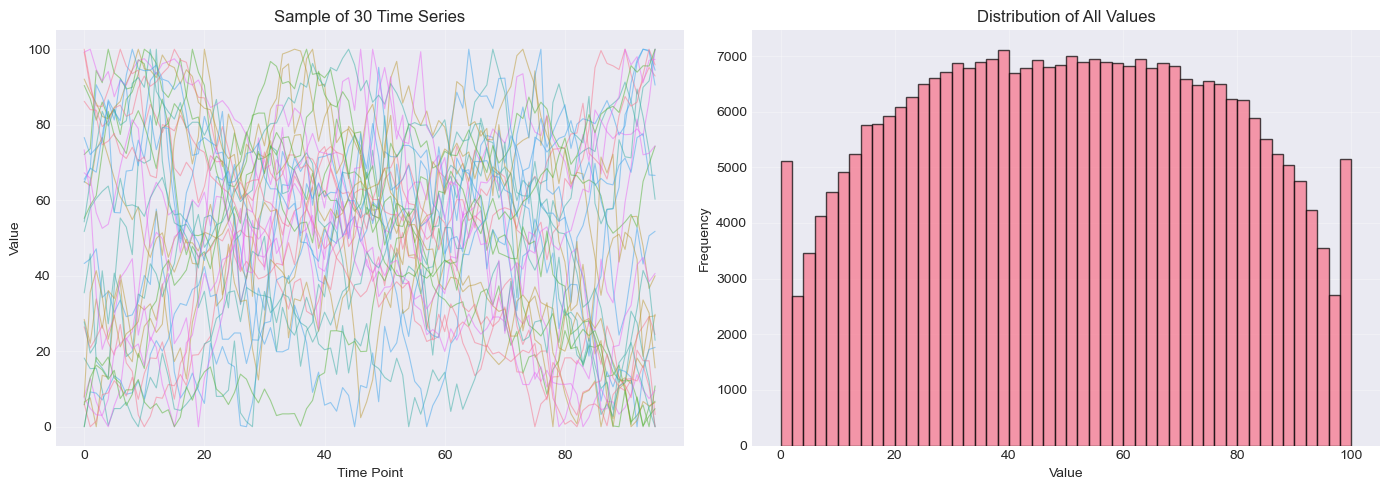

In [5]:
# ## Step 2: Load and Prepare Time Series Data

# %%
def load_validate_data(filepath, sample_size=None):
    """
    Load and validate time series data with optional sampling
    """
    print("="*70)
    print("DATA LOADING AND VALIDATION")
    print("="*70)
    
    # Load data
    df = pd.read_csv(filepath)
    print(f"📁 File: {filepath}")
    print(f"📊 Original shape: {df.shape[0]} series × {df.shape[1]} time points")
    
    # Sample if requested (for testing on large datasets)
    if sample_size and sample_size < len(df):
        print(f"\n🎲 Sampling {sample_size} series for analysis...")
        sample_indices = np.random.choice(len(df), sample_size, replace=False)
        df = df.iloc[sample_indices].reset_index(drop=True)
        print(f"📊 Sampled shape: {df.shape[0]} series × {df.shape[1]} time points")
    
    # Convert to numpy
    data = df.values
    
    # Data quality checks
    print(f"\n🔍 Data Quality Check:")
    print(f"  • Missing values: {np.isnan(data).sum()}")
    print(f"  • Infinite values: {np.isinf(data).sum()}")
    print(f"  • Value range: [{data.min():.2f}, {data.max():.2f}]")
    print(f"  • Mean: {data.mean():.2f}, Std: {data.std():.2f}")
    
    # Memory estimate for DTW
    n_series = len(data)
    estimated_memory = (n_series * (n_series - 1) / 2) * 8 / (1024**2)  # MB
    print(f"\n💾 Estimated memory for distance matrix: {estimated_memory:.1f} MB")
    
    if estimated_memory > 1000:
        print(f"⚠️  Large memory requirement! Consider sampling or batch processing.")
    
    return df, data

# Load your data
INPUT_FILE = "transformed_cumulative_normalized.csv"

# For testing, you can use a smaller sample
# For production, use full dataset
SAMPLE_SIZE = None  # Set to e.g., 100 for quick testing, None for full data

df, time_series_data = load_validate_data(INPUT_FILE, sample_size=SAMPLE_SIZE)

# Quick visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sample time series
n_show = min(30, len(time_series_data))
for i in range(n_show):
    axes[0].plot(time_series_data[i], alpha=0.5, linewidth=0.8)
axes[0].set_title(f'Sample of {n_show} Time Series')
axes[0].set_xlabel('Time Point')
axes[0].set_ylabel('Value')
axes[0].grid(True, alpha=0.3)

# Distribution of values
axes[1].hist(time_series_data.flatten(), bins=50, edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of All Values')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



PREPROCESSING FOR DTW
📊 Applying z-score normalization...
  ✅ Each series normalized to mean=0, std=1

📊 Preprocessed data shape: (3103, 96)
📊 Value range: [-4.24, 3.77]


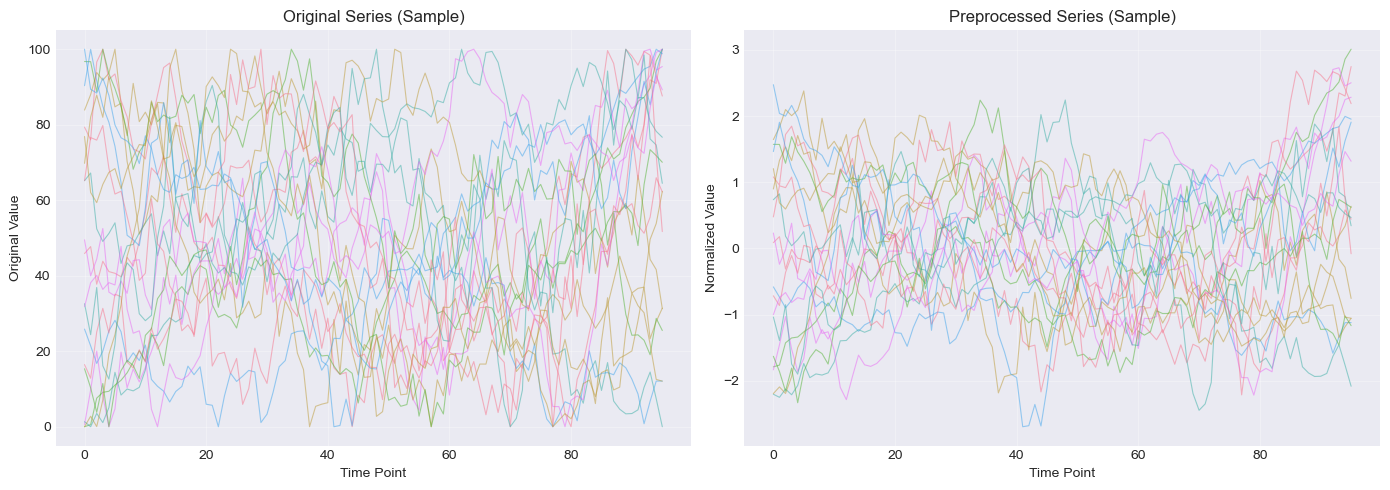

In [6]:
# ## Step 3: Preprocessing for DTW

# %%
def preprocess_for_dtw(data, normalize=True, smooth=False, window_size=3):
    """
    Preprocess time series for DTW distance computation
    """
    print("\n" + "="*70)
    print("PREPROCESSING FOR DTW")
    print("="*70)
    
    processed = data.copy()
    
    # 1. Normalization (z-score per series)
    if normalize:
        print("📊 Applying z-score normalization...")
        for i in range(len(processed)):
            series = processed[i]
            mean = np.mean(series)
            std = np.std(series)
            if std > 0:
                processed[i] = (series - mean) / std
            else:
                processed[i] = series - mean
        print("  ✅ Each series normalized to mean=0, std=1")
    
    # 2. Optional smoothing (reduces noise)
    if smooth and window_size > 1:
        print(f"📊 Applying smoothing (window={window_size})...")
        for i in range(len(processed)):
            series = pd.Series(processed[i])
            smoothed = series.rolling(window=window_size, center=True).mean()
            smoothed = smoothed.fillna(method='bfill').fillna(method='ffill')
            processed[i] = smoothed.values
        print("  ✅ Series smoothed to reduce noise")
    
    # 3. Check for any remaining issues
    if np.any(np.isnan(processed)):
        print("  ⚠️ NaN values detected after preprocessing, fixing...")
        processed = np.nan_to_num(processed)
    
    print(f"\n📊 Preprocessed data shape: {processed.shape}")
    print(f"📊 Value range: [{processed.min():.2f}, {processed.max():.2f}]")
    
    # Visualize preprocessing effect
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Original vs processed
    sample_idx = np.random.choice(len(data), min(20, len(data)), replace=False)
    
    for idx in sample_idx:
        axes[0].plot(data[idx], alpha=0.5, linewidth=0.8)
    axes[0].set_title('Original Series (Sample)')
    axes[0].set_xlabel('Time Point')
    axes[0].set_ylabel('Original Value')
    axes[0].grid(True, alpha=0.3)
    
    for idx in sample_idx:
        axes[1].plot(processed[idx], alpha=0.5, linewidth=0.8)
    axes[1].set_title('Preprocessed Series (Sample)')
    axes[1].set_xlabel('Time Point')
    axes[1].set_ylabel('Normalized Value')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return processed

# Preprocess the data
# Note: Since your data is already normalized (0-100), we might skip normalization
# or use it to ensure each series has comparable variance
preprocessed_data = preprocess_for_dtw(
    time_series_data, 
    normalize=True,  # Standardize each series
    smooth=False,    # No smoothing for now
    window_size=3
)


In [7]:
# ## Step 4: Compute DTW Distance Matrix
# ### This is the computationally intensive step

# %%
def compute_dtw_distances(data, window_ratio=0.1, use_pruning=True, 
                         parallel=False, n_jobs=-1):
    """
    Compute pairwise DTW distances with optimization options
    """
    n_series = len(data)
    series_length = data.shape[1]
    
    print("\n" + "="*70)
    print("DTW DISTANCE COMPUTATION")
    print("="*70)
    print(f"📊 Computing distances for {n_series} series")
    print(f"📊 Series length: {series_length} points")
    print(f"📊 Total comparisons: {n_series * (n_series - 1) // 2:,}")
    
    # Calculate Sakoe-Chiba window
    if window_ratio:
        window = int(window_ratio * series_length)
        print(f"📊 Using Sakoe-Chiba window: {window} (ratio: {window_ratio})")
    else:
        window = None
        print(f"📊 No window constraint (full DTW)")
    
    print(f"📊 Pruning: {'Enabled' if use_pruning else 'Disabled'}")
    
    # Initialize distance matrix
    distance_matrix = np.zeros((n_series, n_series))
    
    # Start timing
    start_time = time.time()
    
    # Compute distances
    print("\n⏳ Computing DTW distances...")
    
    if n_series <= 50:  # Small dataset - show detailed progress
        with tqdm(total=n_series * (n_series - 1) // 2, desc="DTW pairs") as pbar:
            for i in range(n_series):
                for j in range(i + 1, n_series):
                    if window:
                        dist = dtw.distance_fast(
                            data[i], data[j], 
                            window=window, 
                            use_pruning=use_pruning
                        )
                    else:
                        dist = dtw.distance_fast(
                            data[i], data[j], 
                            use_pruning=use_pruning
                        )
                    
                    distance_matrix[i, j] = dist
                    distance_matrix[j, i] = dist
                    pbar.update(1)
    
    else:  # Larger dataset - batch progress
        batch_size = max(1, n_series // 20)
        for i in tqdm(range(n_series), desc="Computing rows"):
            for j in range(i + 1, n_series):
                if window:
                    dist = dtw.distance_fast(
                        data[i], data[j], 
                        window=window, 
                        use_pruning=use_pruning
                    )
                else:
                    dist = dtw.distance_fast(
                        data[i], data[j], 
                        use_pruning=use_pruning
                    )
                
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist
    
    # Timing
    elapsed_time = time.time() - start_time
    comparisons = n_series * (n_series - 1) // 2
    
    print(f"\n✅ Distance computation complete!")
    print(f"⏱️  Total time: {elapsed_time:.2f} seconds")
    print(f"⏱️  Average per comparison: {elapsed_time/comparisons:.4f} seconds")
    print(f"📊 Distance matrix shape: {distance_matrix.shape}")
    print(f"📊 Distance range: [{distance_matrix[distance_matrix > 0].min():.2f}, "
          f"{distance_matrix.max():.2f}]")
    
    return distance_matrix

# Compute DTW distances
# Adjust window_ratio based on your needs:
# - 0.1 (10%) is good for most cases
# - 0.05 (5%) for very similar series
# - 0.2 (20%) for more variation allowed

dtw_distances = compute_dtw_distances(
    preprocessed_data,
    window_ratio=0.1,  # 10% window for efficiency
    use_pruning=True,  # Enable pruning for speed
    parallel=False     # Set True if you have many cores
)


DTW DISTANCE COMPUTATION
📊 Computing distances for 3103 series
📊 Series length: 96 points
📊 Total comparisons: 4,812,753
📊 Using Sakoe-Chiba window: 9 (ratio: 0.1)
📊 Pruning: Enabled

⏳ Computing DTW distances...


Computing rows: 100%|██████████████████████████████████████████████████████████████| 3103/3103 [01:40<00:00, 31.01it/s]


✅ Distance computation complete!
⏱️  Total time: 100.16 seconds
⏱️  Average per comparison: 0.0000 seconds
📊 Distance matrix shape: (3103, 3103)
📊 Distance range: [0.82, 19.51]



DISTANCE MATRIX ANALYSIS


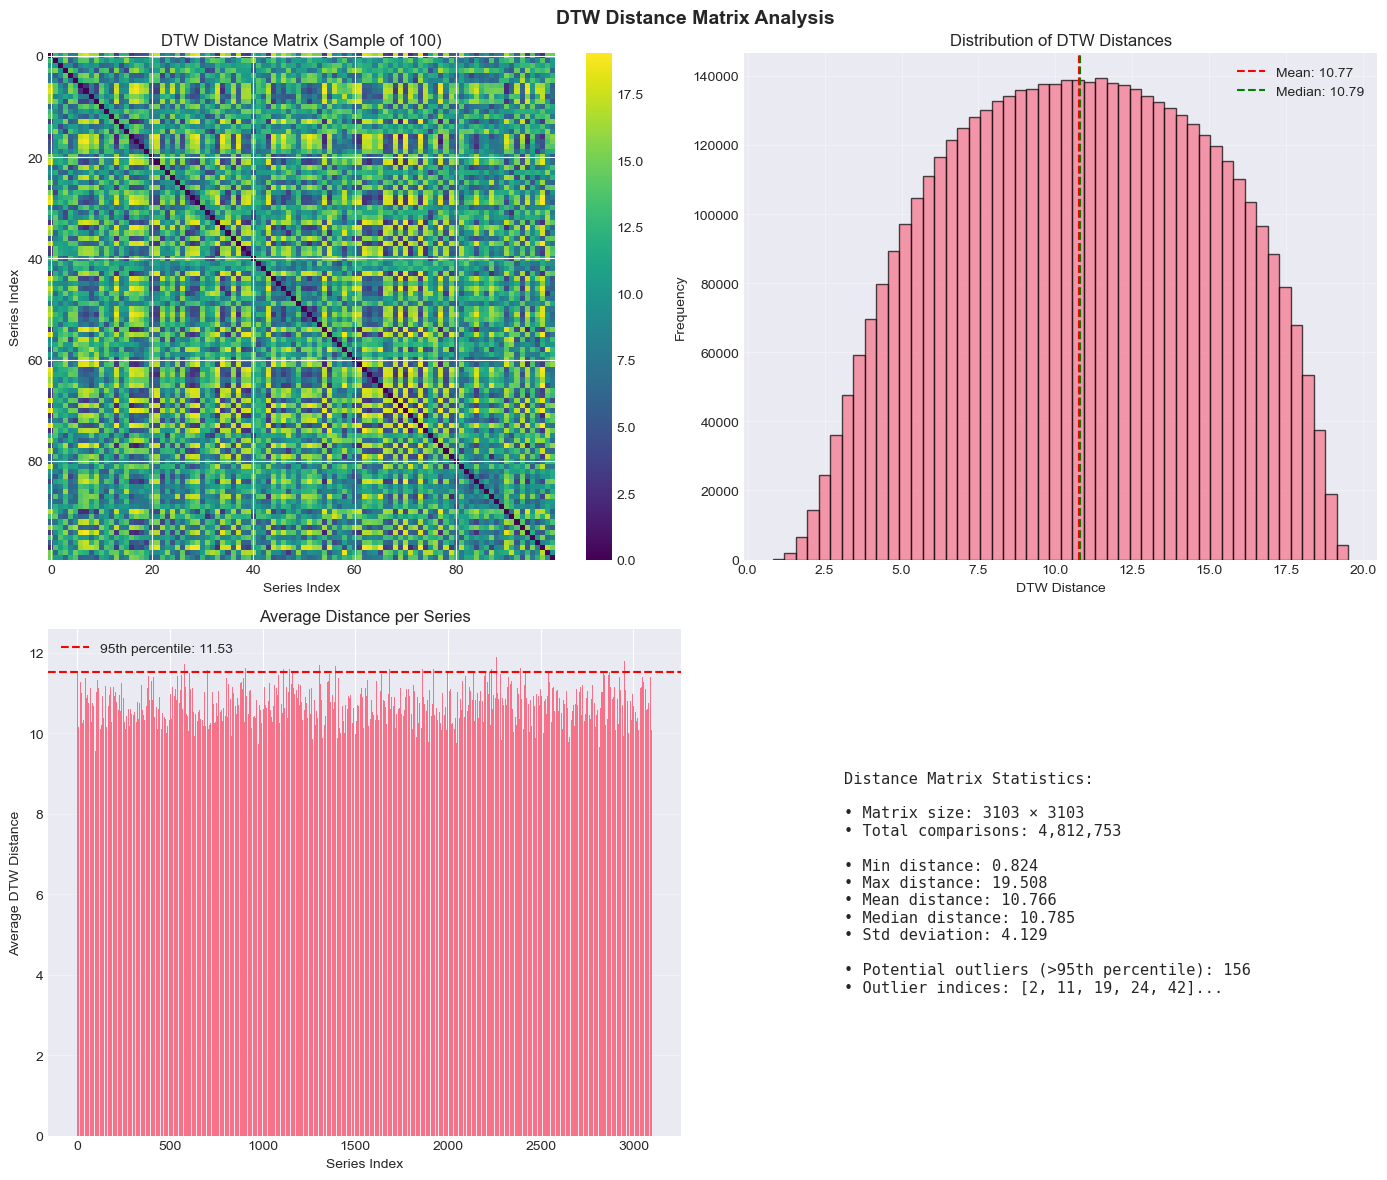

📊 Distance matrix computed successfully
📊 Potential outliers detected: 156


In [8]:
# ## Step 5: Visualize DTW Distance Matrix

# %%
def visualize_distance_matrix(distance_matrix, sample_size=None):
    """
    Visualize the DTW distance matrix
    """
    print("\n" + "="*70)
    print("DISTANCE MATRIX ANALYSIS")
    print("="*70)
    
    # Sample for visualization if matrix is large
    if sample_size and sample_size < len(distance_matrix):
        indices = np.random.choice(len(distance_matrix), sample_size, replace=False)
        indices = np.sort(indices)
        vis_matrix = distance_matrix[np.ix_(indices, indices)]
        title_suffix = f" (Sample of {sample_size})"
    else:
        vis_matrix = distance_matrix
        title_suffix = ""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # 1. Distance matrix heatmap
    im = axes[0, 0].imshow(vis_matrix, cmap='viridis', aspect='auto')
    axes[0, 0].set_title(f'DTW Distance Matrix{title_suffix}')
    axes[0, 0].set_xlabel('Series Index')
    axes[0, 0].set_ylabel('Series Index')
    plt.colorbar(im, ax=axes[0, 0])
    
    # 2. Distance distribution
    # Get upper triangle (excluding diagonal)
    upper_triangle = distance_matrix[np.triu_indices(len(distance_matrix), k=1)]
    axes[0, 1].hist(upper_triangle, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Distribution of DTW Distances')
    axes[0, 1].set_xlabel('DTW Distance')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(np.mean(upper_triangle), color='red', 
                       linestyle='--', label=f'Mean: {np.mean(upper_triangle):.2f}')
    axes[0, 1].axvline(np.median(upper_triangle), color='green', 
                       linestyle='--', label=f'Median: {np.median(upper_triangle):.2f}')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Average distance per series
    avg_distances = np.mean(distance_matrix, axis=1)
    axes[1, 0].bar(range(len(avg_distances)), avg_distances)
    axes[1, 0].set_title('Average Distance per Series')
    axes[1, 0].set_xlabel('Series Index')
    axes[1, 0].set_ylabel('Average DTW Distance')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Identify potential outliers (high average distance)
    outlier_threshold = np.percentile(avg_distances, 95)
    outlier_indices = np.where(avg_distances > outlier_threshold)[0]
    axes[1, 0].axhline(outlier_threshold, color='red', linestyle='--', 
                       label=f'95th percentile: {outlier_threshold:.2f}')
    axes[1, 0].legend()
    
    # 4. Distance statistics
    axes[1, 1].axis('off')
    stats_text = f"""
    Distance Matrix Statistics:
    
    • Matrix size: {distance_matrix.shape[0]} × {distance_matrix.shape[1]}
    • Total comparisons: {len(upper_triangle):,}
    
    • Min distance: {upper_triangle.min():.3f}
    • Max distance: {upper_triangle.max():.3f}
    • Mean distance: {upper_triangle.mean():.3f}
    • Median distance: {np.median(upper_triangle):.3f}
    • Std deviation: {upper_triangle.std():.3f}
    
    • Potential outliers (>95th percentile): {len(outlier_indices)}
    • Outlier indices: {outlier_indices[:5].tolist()}{'...' if len(outlier_indices) > 5 else ''}
    """
    axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11, 
                    verticalalignment='center', family='monospace')
    
    plt.suptitle('DTW Distance Matrix Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Distance matrix computed successfully")
    print(f"📊 Potential outliers detected: {len(outlier_indices)}")
    
    return outlier_indices

# Visualize the distance matrix
potential_outliers = visualize_distance_matrix(
    dtw_distances, 
    sample_size=100 if len(dtw_distances) > 100 else None
)

In [9]:
# ## Step 6: HDBSCAN Parameter Tuning for DTW Distances

# %%
def tune_hdbscan_dtw(distance_matrix, min_size_range=None, min_samples_range=None):
    """
    Find optimal HDBSCAN parameters for DTW distance matrix
    """
    n_series = len(distance_matrix)
    
    print("\n" + "="*70)
    print("HDBSCAN PARAMETER TUNING")
    print("="*70)
    
    # Set default ranges based on dataset size
    if min_size_range is None:
        if n_series < 50:
            min_size_range = [3, 4, 5]
        elif n_series < 200:
            min_size_range = [5, 8, 10, 12]
        else:
            min_size_range = [10, 15, 20, 25]
    
    if min_samples_range is None:
        min_samples_range = [None, 3, 5]
    
    print(f"Testing min_cluster_size: {min_size_range}")
    print(f"Testing min_samples: {min_samples_range}")
    
    results = []
    best_score = -1
    best_params = None
    
    print("\n⏳ Testing parameter combinations...")
    
    for min_size in tqdm(min_size_range, desc="Parameter search"):
        for min_samp in min_samples_range:
            # Skip invalid combinations
            if min_samp and min_samp > min_size:
                continue
            
            try:
                # Create clusterer
                clusterer = hdbscan.HDBSCAN(
                    min_cluster_size=min_size,
                    min_samples=min_samp,
                    metric='precomputed',
                    cluster_selection_method='eom'
                )
                
                # Fit and predict
                labels = clusterer.fit_predict(distance_matrix)
                
                # Calculate metrics
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                n_noise = list(labels).count(-1)
                noise_ratio = n_noise / n_series
                
                # Skip poor clusterings
                if n_clusters < 2 or noise_ratio > 0.5:
                    continue
                
                # Calculate silhouette score
                valid_mask = labels != -1
                if np.sum(valid_mask) > n_clusters:
                    score = silhouette_score(
                        distance_matrix, 
                        labels, 
                        metric='precomputed'
                    )
                    
                    # Weighted score (balance quality and coverage)
                    coverage = 1 - noise_ratio
                    weighted_score = score * (coverage ** 0.5)  # Square root to reduce penalty
                    
                    results.append({
                        'min_cluster_size': min_size,
                        'min_samples': min_samp if min_samp else min_size,
                        'n_clusters': n_clusters,
                        'n_noise': n_noise,
                        'noise_ratio': f"{noise_ratio:.2%}",
                        'silhouette': f"{score:.3f}",
                        'weighted_score': f"{weighted_score:.3f}"
                    })
                    
                    if weighted_score > best_score:
                        best_score = weighted_score
                        best_params = {
                            'min_cluster_size': min_size,
                            'min_samples': min_samp,
                            'n_clusters': n_clusters,
                            'n_noise': n_noise,
                            'clusterer': clusterer,
                            'labels': labels
                        }
            except Exception as e:
                continue
    
    if results:
        results_df = pd.DataFrame(results)
        
        print("\n📊 Parameter Search Results:")
        print("="*70)
        print(results_df.to_string(index=False))
        
        if best_params:
            print(f"\n🏆 Best Parameters:")
            print(f"  • min_cluster_size: {best_params['min_cluster_size']}")
            print(f"  • min_samples: {best_params.get('min_samples', best_params['min_cluster_size'])}")
            print(f"  • Resulting clusters: {best_params['n_clusters']}")
            print(f"  • Noise points: {best_params['n_noise']}")
    else:
        print("⚠️ No valid clustering found. Using default parameters.")
        best_params = {'min_cluster_size': 10, 'min_samples': 5}
    
    return best_params, results

# Tune HDBSCAN parameters
best_params, tuning_results = tune_hdbscan_dtw(dtw_distances)


HDBSCAN PARAMETER TUNING
Testing min_cluster_size: [10, 15, 20, 25]
Testing min_samples: [None, 3, 5]

⏳ Testing parameter combinations...


Parameter search: 100%|██████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.68s/it]

⚠️ No valid clustering found. Using default parameters.


In [10]:
# ## Step 7: Run HDBSCAN with Optimal Parameters

# %%
def run_hdbscan_dtw(distance_matrix, params):
    """
    Run HDBSCAN with DTW distances using optimal parameters
    """
    print("\n" + "="*70)
    print("HDBSCAN CLUSTERING WITH DTW")
    print("="*70)
    
    # Use existing clusterer if available
    if 'clusterer' in params and 'labels' in params:
        clusterer = params['clusterer']
        labels = params['labels']
        print("✅ Using pre-computed clustering from parameter search")
    else:
        # Create new clusterer
        print("📊 Creating new HDBSCAN clusterer...")
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=params['min_cluster_size'],
            min_samples=params.get('min_samples'),
            metric='precomputed',
            cluster_selection_method='eom',
            prediction_data=True
        )
        
        print("⏳ Fitting clusterer...")
        labels = clusterer.fit_predict(distance_matrix)
    
    # Get cluster information
    probabilities = clusterer.probabilities_
    outlier_scores = clusterer.outlier_scores_
    
    # Statistics
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    print(f"\n✅ Clustering Complete!")
    print(f"\n📊 RESULTS SUMMARY:")
    print(f"  • Total clusters found: {n_clusters}")
    print(f"  • Noise/outlier points: {n_noise} ({n_noise/len(labels)*100:.1f}%)")
    print(f"  • Average membership probability: {np.mean(probabilities):.3f}")
    
    # Detailed cluster information
    print(f"\n📈 CLUSTER DETAILS:")
    cluster_info = []
    
    for c in range(n_clusters):
        mask = labels == c
        size = np.sum(mask)
        avg_prob = np.mean(probabilities[mask])
        min_prob = np.min(probabilities[mask])
        max_prob = np.max(probabilities[mask])
        
        cluster_info.append({
            'Cluster': c,
            'Size': size,
            'Percentage': f"{size/len(labels)*100:.1f}%",
            'Avg_Prob': f"{avg_prob:.3f}",
            'Min_Prob': f"{min_prob:.3f}",
            'Max_Prob': f"{max_prob:.3f}"
        })
        
        print(f"  Cluster {c}: {size} series ({size/len(labels)*100:.1f}%), "
              f"prob: {avg_prob:.3f} [{min_prob:.3f}-{max_prob:.3f}]")
    
    if n_noise > 0:
        print(f"  Noise (-1): {n_noise} series ({n_noise/len(labels)*100:.1f}%)")
    
    # Quality metrics
    valid_mask = labels != -1
    if np.sum(valid_mask) > 1:
        silhouette = silhouette_score(
            distance_matrix[valid_mask][:, valid_mask], 
            labels[valid_mask], 
            metric='precomputed'
        )
        print(f"\n📊 QUALITY METRICS:")
        print(f"  • Silhouette Score: {silhouette:.3f} (range: -1 to 1)")
    
    return clusterer, labels, probabilities, outlier_scores, cluster_info

# Run HDBSCAN with best parameters
hdbscan_clusterer, hdbscan_labels, hdbscan_probs, hdbscan_outliers, cluster_info = \
    run_hdbscan_dtw(dtw_distances, best_params)



HDBSCAN CLUSTERING WITH DTW
📊 Creating new HDBSCAN clusterer...
⏳ Fitting clusterer...

✅ Clustering Complete!

📊 RESULTS SUMMARY:
  • Total clusters found: 2
  • Noise/outlier points: 1889 (60.9%)
  • Average membership probability: 0.259

📈 CLUSTER DETAILS:
  Cluster 0: 668 series (21.5%), prob: 0.646 [0.492-1.000]
  Cluster 1: 546 series (17.6%), prob: 0.684 [0.520-1.000]
  Noise (-1): 1889 series (60.9%)

📊 QUALITY METRICS:
  • Silhouette Score: 0.690 (range: -1 to 1)


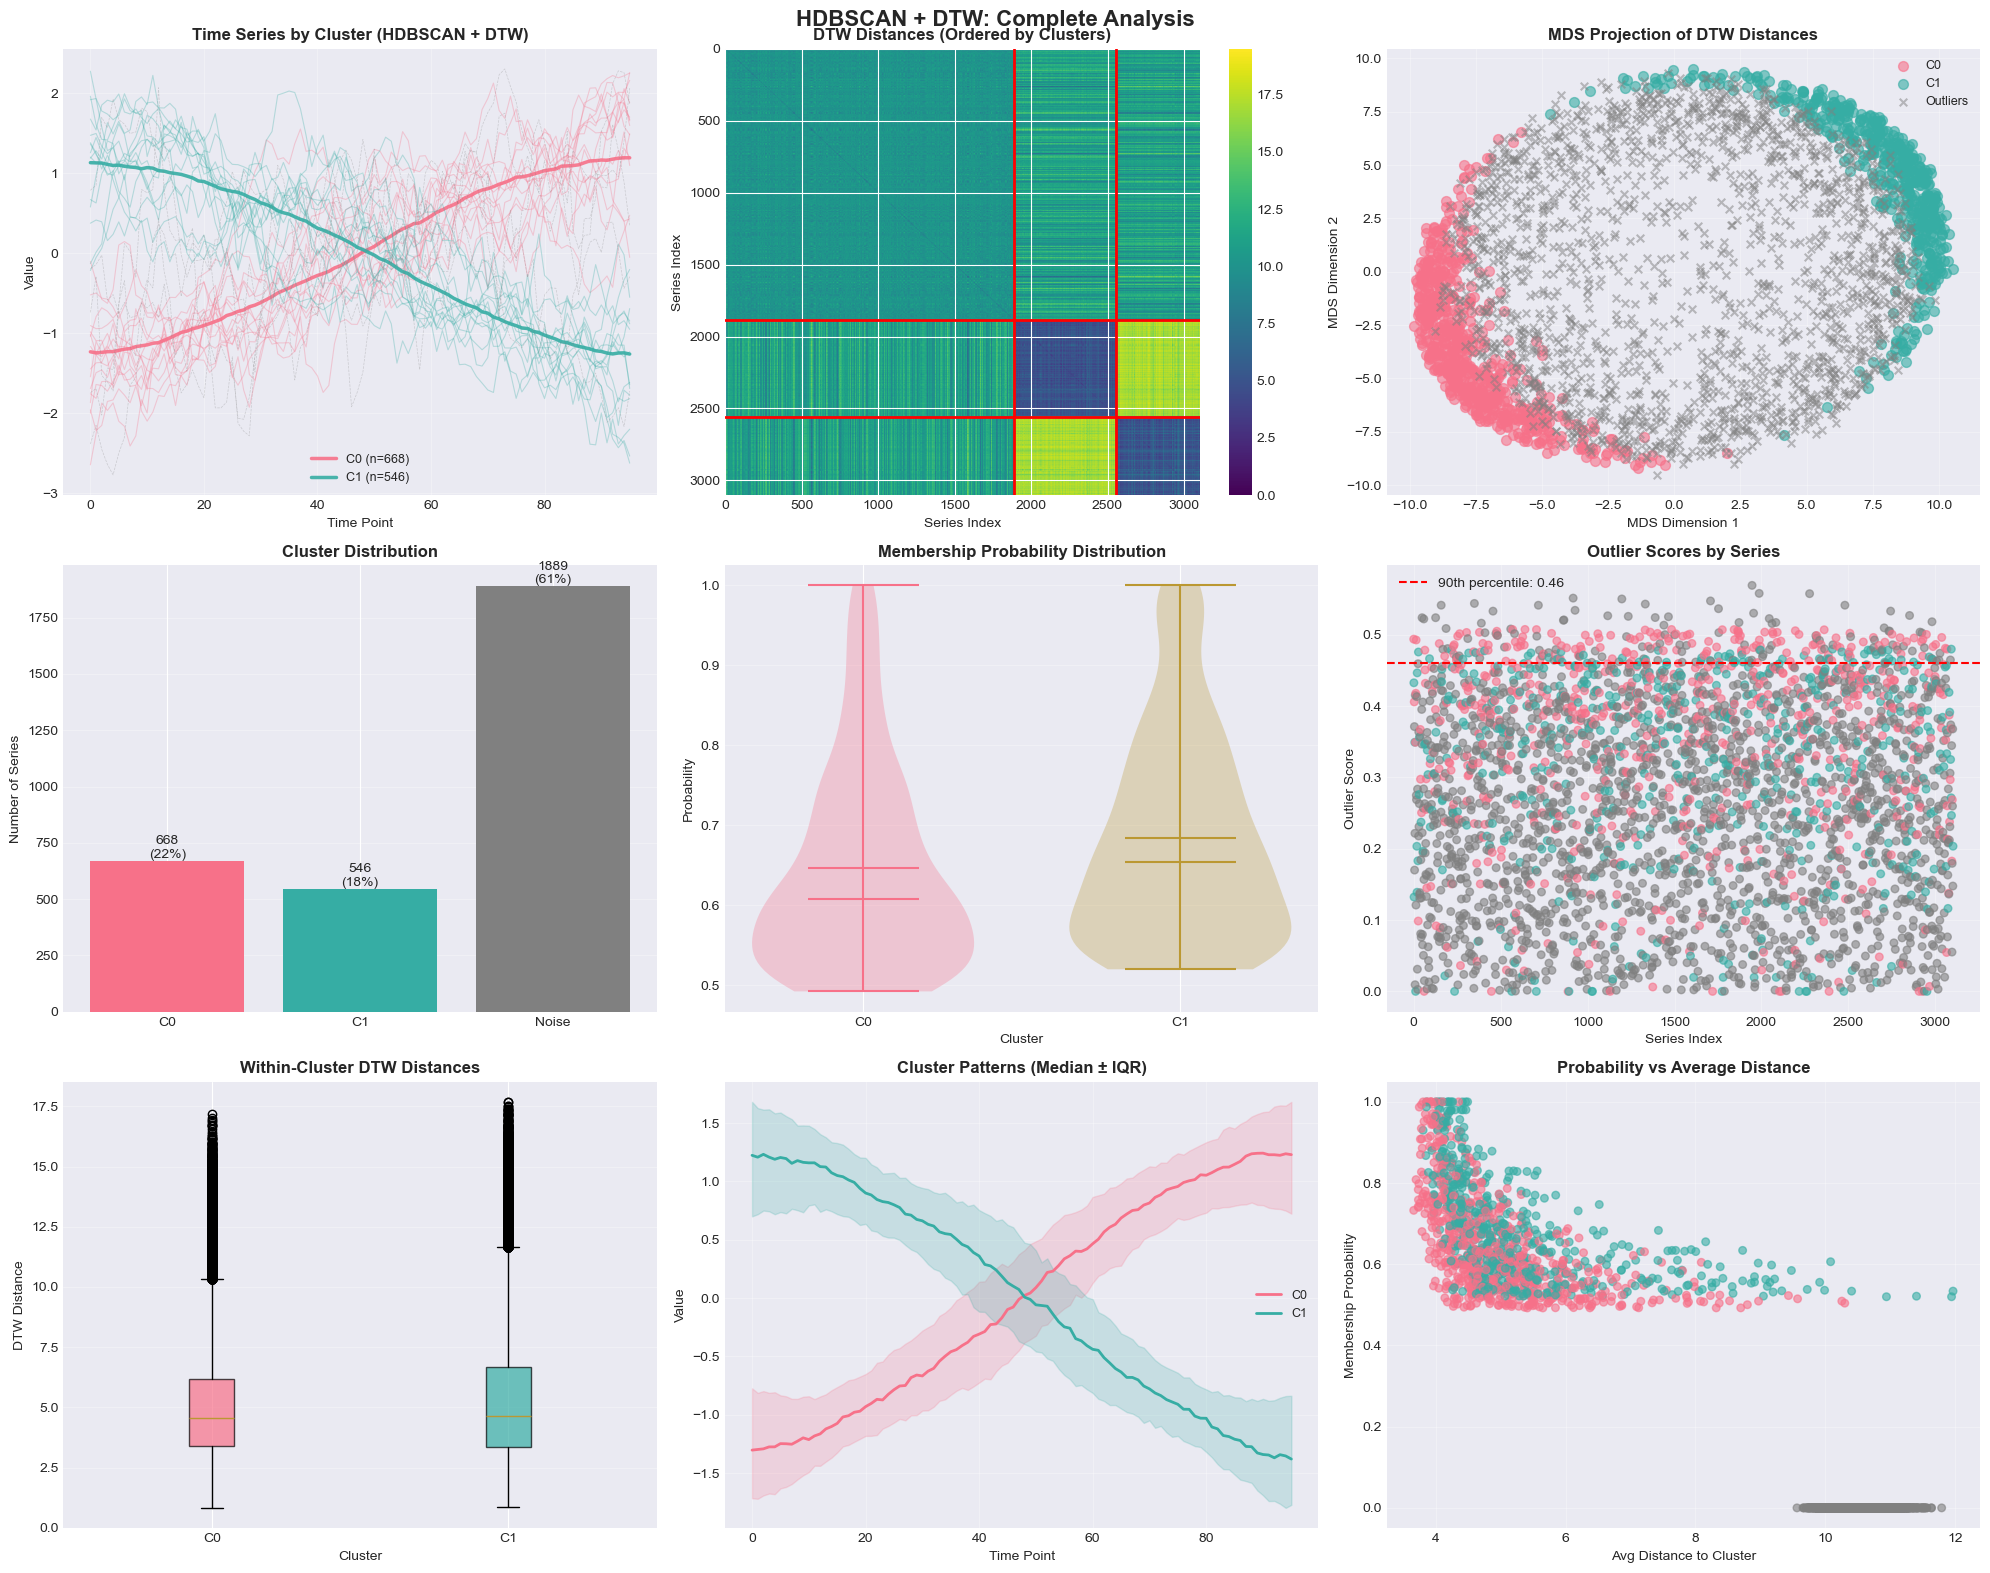

In [11]:
# ## Step 8: Visualize HDBSCAN + DTW Results

# %%
def visualize_hdbscan_dtw_results(original_data, distance_matrix, labels, 
                                  probabilities, outlier_scores):
    """
    Comprehensive visualization of HDBSCAN + DTW clustering
    """
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    colors = sns.color_palette("husl", n_clusters)
    
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Clustered time series
    ax1 = plt.subplot(3, 3, 1)
    for c in range(n_clusters):
        cluster_data = original_data[labels == c]
        # Plot sample series
        for series in cluster_data[:min(15, len(cluster_data))]:
            ax1.plot(series, color=colors[c], alpha=0.3, linewidth=0.8)
        # Plot mean
        if len(cluster_data) > 0:
            mean_series = np.mean(cluster_data, axis=0)
            ax1.plot(mean_series, color=colors[c], linewidth=2.5, 
                    label=f'C{c} (n={len(cluster_data)})', alpha=0.9)
    
    # Plot outliers
    if -1 in labels:
        outlier_data = original_data[labels == -1]
        for series in outlier_data[:min(5, len(outlier_data))]:
            ax1.plot(series, 'gray', alpha=0.3, linewidth=0.5, linestyle='--')
    
    ax1.set_title('Time Series by Cluster (HDBSCAN + DTW)', fontweight='bold')
    ax1.set_xlabel('Time Point')
    ax1.set_ylabel('Value')
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # 2. Distance matrix with cluster ordering
    ax2 = plt.subplot(3, 3, 2)
    
    # Reorder by clusters
    sorted_indices = np.argsort(labels)
    sorted_matrix = distance_matrix[sorted_indices][:, sorted_indices]
    sorted_labels = labels[sorted_indices]
    
    im = ax2.imshow(sorted_matrix, cmap='viridis', aspect='auto')
    
    # Add cluster boundaries
    boundaries = []
    current_label = sorted_labels[0]
    for i, label in enumerate(sorted_labels):
        if label != current_label:
            boundaries.append(i)
            current_label = label
    
    for boundary in boundaries:
        ax2.axhline(y=boundary-0.5, color='red', linewidth=2)
        ax2.axvline(x=boundary-0.5, color='red', linewidth=2)
    
    ax2.set_title('DTW Distances (Ordered by Clusters)', fontweight='bold')
    ax2.set_xlabel('Series Index')
    ax2.set_ylabel('Series Index')
    plt.colorbar(im, ax=ax2)
    
    # 3. MDS/PCA projection
    ax3 = plt.subplot(3, 3, 3)
    
    # Use MDS for 2D projection of DTW distances
    from sklearn.manifold import MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(distance_matrix)
    
    for c in range(n_clusters):
        mask = labels == c
        ax3.scatter(coords[mask, 0], coords[mask, 1], 
                   c=[colors[c]], label=f'C{c}', alpha=0.6, s=50)
    
    if -1 in labels:
        outlier_mask = labels == -1
        ax3.scatter(coords[outlier_mask, 0], coords[outlier_mask, 1],
                   c='gray', marker='x', label='Outliers', alpha=0.5, s=30)
    
    ax3.set_title('MDS Projection of DTW Distances', fontweight='bold')
    ax3.set_xlabel('MDS Dimension 1')
    ax3.set_ylabel('MDS Dimension 2')
    ax3.legend(loc='best', fontsize=9)
    ax3.grid(True, alpha=0.3)
    
    # 4. Cluster sizes
    ax4 = plt.subplot(3, 3, 4)
    cluster_sizes = [np.sum(labels == i) for i in range(n_clusters)]
    if -1 in labels:
        cluster_sizes.append(np.sum(labels == -1))
        names = [f'C{i}' for i in range(n_clusters)] + ['Noise']
        bar_colors = list(colors) + [(0.5, 0.5, 0.5)]
    else:
        names = [f'C{i}' for i in range(n_clusters)]
        bar_colors = colors
    
    bars = ax4.bar(names, cluster_sizes, color=bar_colors)
    
    for bar, size in zip(bars, cluster_sizes):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{size}\n({size/len(labels)*100:.0f}%)',
                ha='center', va='bottom', fontsize=10)
    
    ax4.set_title('Cluster Distribution', fontweight='bold')
    ax4.set_ylabel('Number of Series')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # 5. Membership probabilities
    ax5 = plt.subplot(3, 3, 5)
    for c in range(n_clusters):
        cluster_probs = probabilities[labels == c]
        if len(cluster_probs) > 0:
            ax5.violinplot([cluster_probs], positions=[c], widths=0.7,
                          showmeans=True, showmedians=True)
    
    ax5.set_title('Membership Probability Distribution', fontweight='bold')
    ax5.set_xlabel('Cluster')
    ax5.set_ylabel('Probability')
    ax5.set_xticks(range(n_clusters))
    ax5.set_xticklabels([f'C{i}' for i in range(n_clusters)])
    ax5.grid(True, alpha=0.3, axis='y')
    
    # 6. Outlier scores
    ax6 = plt.subplot(3, 3, 6)
    
    # Color points by cluster
    scatter_colors = []
    for label in labels:
        if label == -1:
            scatter_colors.append('gray')
        else:
            scatter_colors.append(colors[label])
    
    ax6.scatter(range(len(outlier_scores)), outlier_scores, 
               c=scatter_colors, alpha=0.6, s=30)
    
    threshold = np.percentile(outlier_scores, 90)
    ax6.axhline(y=threshold, color='red', linestyle='--', 
               label=f'90th percentile: {threshold:.2f}')
    
    ax6.set_title('Outlier Scores by Series', fontweight='bold')
    ax6.set_xlabel('Series Index')
    ax6.set_ylabel('Outlier Score')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 7. Within-cluster distances
    ax7 = plt.subplot(3, 3, 7)
    
    within_distances = []
    cluster_names = []
    
    for c in range(n_clusters):
        mask = labels == c
        if np.sum(mask) > 1:
            cluster_indices = np.where(mask)[0]
            cluster_dist = distance_matrix[np.ix_(cluster_indices, cluster_indices)]
            # Get upper triangle
            upper_tri = cluster_dist[np.triu_indices(len(cluster_dist), k=1)]
            if len(upper_tri) > 0:
                within_distances.append(upper_tri)
                cluster_names.append(f'C{c}')
    
    if within_distances:
        bp = ax7.boxplot(within_distances, labels=cluster_names, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors[:len(within_distances)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    ax7.set_title('Within-Cluster DTW Distances', fontweight='bold')
    ax7.set_xlabel('Cluster')
    ax7.set_ylabel('DTW Distance')
    ax7.grid(True, alpha=0.3, axis='y')
    
    # 8. Temporal patterns
    ax8 = plt.subplot(3, 3, 8)
    
    for c in range(n_clusters):
        cluster_data = original_data[labels == c]
        if len(cluster_data) > 0:
            # Calculate envelope
            upper = np.percentile(cluster_data, 75, axis=0)
            lower = np.percentile(cluster_data, 25, axis=0)
            median = np.median(cluster_data, axis=0)
            
            time_points = range(len(median))
            ax8.plot(time_points, median, color=colors[c], 
                    linewidth=2, label=f'C{c}')
            ax8.fill_between(time_points, lower, upper, 
                            color=colors[c], alpha=0.2)
    
    ax8.set_title('Cluster Patterns (Median ± IQR)', fontweight='bold')
    ax8.set_xlabel('Time Point')
    ax8.set_ylabel('Value')
    ax8.legend(loc='best', fontsize=9)
    ax8.grid(True, alpha=0.3)
    
    # 9. Probability vs Distance
    ax9 = plt.subplot(3, 3, 9)
    
    # Calculate average distance to cluster center for each point
    avg_distances = []
    for i, label in enumerate(labels):
        if label != -1:
            cluster_mask = labels == label
            cluster_indices = np.where(cluster_mask)[0]
            if len(cluster_indices) > 1:
                distances_to_cluster = distance_matrix[i, cluster_indices]
                avg_dist = np.mean(distances_to_cluster)
                avg_distances.append(avg_dist)
            else:
                avg_distances.append(0)
        else:
            avg_distances.append(np.mean(distance_matrix[i]))
    
    # Color by cluster
    point_colors = [colors[l] if l >= 0 else 'gray' for l in labels]
    
    ax9.scatter(avg_distances, probabilities, c=point_colors, alpha=0.6, s=30)
    ax9.set_title('Probability vs Average Distance', fontweight='bold')
    ax9.set_xlabel('Avg Distance to Cluster')
    ax9.set_ylabel('Membership Probability')
    ax9.grid(True, alpha=0.3)
    
    plt.suptitle('HDBSCAN + DTW: Complete Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize results
visualize_hdbscan_dtw_results(
    preprocessed_data,  # Or use original time_series_data
    dtw_distances,
    hdbscan_labels,
    hdbscan_probs,
    hdbscan_outliers
)

In [12]:
# ## Step 9: Analyze and Interpret Clusters

# %%
def analyze_dtw_clusters(original_data, labels, distances, probabilities):
    """
    Detailed analysis of each cluster from HDBSCAN + DTW
    """
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    print("\n" + "="*70)
    print("DETAILED CLUSTER ANALYSIS")
    print("="*70)
    
    cluster_profiles = []
    
    for c in range(n_clusters):
        cluster_mask = labels == c
        cluster_data = original_data[cluster_mask]
        cluster_probs = probabilities[cluster_mask]
        
        if len(cluster_data) == 0:
            continue
        
        print(f"\n{'='*60}")
        print(f"CLUSTER {c}")
        print(f"{'='*60}")
        
        # Basic info
        print(f"📊 Size: {len(cluster_data)} series ({len(cluster_data)/len(labels)*100:.1f}%)")
        print(f"📊 Avg membership: {np.mean(cluster_probs):.3f}")
        print(f"📊 Membership range: [{np.min(cluster_probs):.3f}, {np.max(cluster_probs):.3f}]")
        
        # Pattern characteristics
        mean_series = np.mean(cluster_data, axis=0)
        std_series = np.std(cluster_data, axis=0)
        
        # Trend analysis
        x = np.arange(len(mean_series))
        z = np.polyfit(x, mean_series, 1)
        trend = z[0]
        
        print(f"\n📈 Pattern Characteristics:")
        print(f"  • Start value: {mean_series[0]:.2f}")
        print(f"  • End value: {mean_series[-1]:.2f}")
        print(f"  • Total change: {mean_series[-1] - mean_series[0]:.2f}")
        print(f"  • Average value: {np.mean(mean_series):.2f}")
        print(f"  • Volatility (avg std): {np.mean(std_series):.3f}")
        
        # Trend interpretation
        if abs(trend) < 0.01:
            trend_type = "Flat/Stable"
        elif trend > 0.1:
            trend_type = "Strong Upward"
        elif trend > 0:
            trend_type = "Moderate Upward"
        elif trend < -0.1:
            trend_type = "Strong Downward"
        else:
            trend_type = "Moderate Downward"
        
        print(f"  • Trend: {trend_type} (slope: {trend:.4f})")
        
        # Cluster cohesion
        cluster_indices = np.where(cluster_mask)[0]
        if len(cluster_indices) > 1:
            within_cluster_distances = distances[np.ix_(cluster_indices, cluster_indices)]
            avg_within = np.mean(within_cluster_distances[np.triu_indices(len(cluster_indices), k=1)])
            
            # Compare to overall average
            overall_avg = np.mean(distances[np.triu_indices(len(distances), k=1)])
            cohesion_ratio = avg_within / overall_avg
            
            print(f"\n🎯 Cluster Cohesion:")
            print(f"  • Avg within-cluster distance: {avg_within:.3f}")
            print(f"  • Cohesion ratio: {cohesion_ratio:.3f}")
            
            if cohesion_ratio < 0.5:
                cohesion_desc = "Very tight"
            elif cohesion_ratio < 0.75:
                cohesion_desc = "Tight"
            elif cohesion_ratio < 1.0:
                cohesion_desc = "Moderate"
            else:
                cohesion_desc = "Loose"
            
            print(f"  • Cohesion: {cohesion_desc}")
        
        # Find medoid (most representative series)
        if len(cluster_indices) > 1:
            cluster_distances = distances[np.ix_(cluster_indices, cluster_indices)]
            medoid_idx = cluster_indices[np.argmin(np.sum(cluster_distances, axis=1))]
            print(f"\n🔍 Most representative series: Index {medoid_idx}")
        
        # Market interpretation (for volatility data)
        print(f"\n💡 Interpretation:")
        
        volatility = np.mean([np.std(series) for series in cluster_data])
        
        if volatility > np.percentile([np.std(s) for s in original_data], 75):
            vol_level = "High"
        elif volatility < np.percentile([np.std(s) for s in original_data], 25):
            vol_level = "Low"
        else:
            vol_level = "Medium"
        
        if vol_level == "High" and trend_type.endswith("Upward"):
            interpretation = "Volatile Bull Market - High opportunity, high risk"
        elif vol_level == "High" and trend_type.endswith("Downward"):
            interpretation = "Volatile Bear Market - High risk, potential reversals"
        elif vol_level == "Low" and trend_type == "Flat/Stable":
            interpretation = "Quiet Market - Low volatility, range-bound"
        elif vol_level == "Low" and trend_type.endswith("Upward"):
            interpretation = "Steady Growth - Consistent upward movement"
        elif vol_level == "Low" and trend_type.endswith("Downward"):
            interpretation = "Steady Decline - Consistent downward movement"
        else:
            interpretation = "Mixed Market Conditions"
        
        print(f"  → {interpretation}")
        
        cluster_profiles.append({
            'cluster': c,
            'size': len(cluster_data),
            'trend': trend_type,
            'volatility': vol_level,
            'cohesion': cohesion_desc if 'cohesion_desc' in locals() else 'N/A',
            'interpretation': interpretation
        })
    
    # Analyze outliers
    if -1 in labels:
        outlier_indices = np.where(labels == -1)[0]
        outlier_data = original_data[outlier_indices]
        
        print(f"\n{'='*60}")
        print(f"OUTLIERS/NOISE")
        print(f"{'='*60}")
        print(f"📊 Count: {len(outlier_indices)} ({len(outlier_indices)/len(labels)*100:.1f}%)")
        
        if len(outlier_indices) > 0:
            # Analyze why they're outliers
            avg_distances_to_all = np.mean(distances[outlier_indices], axis=1)
            
            print(f"\n🔍 Outlier Analysis:")
            print(f"  • Avg distance to all series: {np.mean(avg_distances_to_all):.3f}")
            print(f"  • Most extreme outlier: Index {outlier_indices[np.argmax(avg_distances_to_all)]}")
            
            print(f"\n📊 Sample outliers (first 5):")
            for i, idx in enumerate(outlier_indices[:5]):
                series = outlier_data[i]
                print(f"  • Series {idx}: range=[{series.min():.2f}, {series.max():.2f}], "
                      f"volatility={np.std(series):.3f}")
    
    return cluster_profiles

# Analyze clusters
cluster_profiles = analyze_dtw_clusters(
    preprocessed_data,
    hdbscan_labels,
    dtw_distances,
    hdbscan_probs
)



DETAILED CLUSTER ANALYSIS

CLUSTER 0
📊 Size: 668 series (21.5%)
📊 Avg membership: 0.646
📊 Membership range: [0.492, 1.000]

📈 Pattern Characteristics:
  • Start value: -1.23
  • End value: 1.19
  • Total change: 2.43
  • Average value: 0.00
  • Volatility (avg std): 0.537
  • Trend: Moderate Upward (slope: 0.0302)

🎯 Cluster Cohesion:
  • Avg within-cluster distance: 4.997
  • Cohesion ratio: 0.464
  • Cohesion: Very tight

🔍 Most representative series: Index 416

💡 Interpretation:
  → Mixed Market Conditions

CLUSTER 1
📊 Size: 546 series (17.6%)
📊 Avg membership: 0.684
📊 Membership range: [0.520, 1.000]

📈 Pattern Characteristics:
  • Start value: 1.13
  • End value: -1.26
  • Total change: -2.39
  • Average value: 0.00
  • Volatility (avg std): 0.557
  • Trend: Moderate Downward (slope: -0.0295)

🎯 Cluster Cohesion:
  • Avg within-cluster distance: 5.340
  • Cohesion ratio: 0.496
  • Cohesion: Very tight

🔍 Most representative series: Index 369

💡 Interpretation:
  → Mixed Market Co

In [ ]:
# ## Step 10: Export Results

# %%
def export_hdbscan_dtw_results(labels, probabilities, outlier_scores, 
                               profiles, original_df, 
                               output_prefix="hdbscan_dtw"):
    """
    Export comprehensive results from HDBSCAN + DTW clustering
    """
    print("\n" + "="*70)
    print("EXPORTING RESULTS")
    print("="*70)
    
    # 1. Cluster assignments
    assignments_df = pd.DataFrame({
        'series_index': range(len(labels)),
        'cluster': labels,
        'probability': probabilities,
        'outlier_score': outlier_scores,
        'is_outlier': labels == -1,
        'is_core': probabilities > 0.9,  # High probability = core member
        'is_border': (probabilities > 0.1) & (probabilities <= 0.9)  # Border points
    })
    
    assignments_file = f'{output_prefix}_assignments.csv'
    assignments_df.to_csv(assignments_file, index=False)
    print(f"✅ Saved: {assignments_file}")
    
    # 2. Cluster summary with interpretations
    summary_data = []
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    for c in range(n_clusters):
        mask = labels == c
        profile = next((p for p in profiles if p['cluster'] == c), {})
        
        summary_data.append({
            'cluster': c,
            'size': np.sum(mask),
            'percentage': f"{np.sum(mask) / len(labels) * 100:.1f}%",
            'core_members': np.sum((labels == c) & (probabilities > 0.9)),
            'border_members': np.sum((labels == c) & (probabilities <= 0.9)),
            'avg_probability': f"{np.mean(probabilities[mask]):.3f}",
            'trend': profile.get('trend', 'Unknown'),
            'volatility': profile.get('volatility', 'Unknown'),
            'cohesion': profile.get('cohesion', 'Unknown'),
            'interpretation': profile.get('interpretation', 'Unknown')
        })
    
    # Add outliers
    if -1 in labels:
        summary_data.append({
            'cluster': -1,
            'size': np.sum(labels == -1),
            'percentage': f"{np.sum(labels == -1) / len(labels) * 100:.1f}%",
            'core_members': 0,
            'border_members': 0,
            'avg_probability': '0.000',
            'trend': 'N/A',
            'volatility': 'N/A',
            'cohesion': 'N/A',
            'interpretation': 'Outliers/Anomalous patterns'
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_file = f'{output_prefix}_summary.csv'
    summary_df.to_csv(summary_file, index=False)
    print(f"✅ Saved: {summary_file}")
    
    # 3. Representative series (medoids)
    medoids_data = []
    for c in range(n_clusters):
        cluster_indices = np.where(labels == c)[0]
        if len(cluster_indices) > 1:
            # Find medoid
            cluster_distances = dtw_distances[np.ix_(cluster_indices, cluster_indices)]
            medoid_local_idx = np.argmin(np.sum(cluster_distances, axis=1))
            medoid_global_idx = cluster_indices[medoid_local_idx]
            
            medoid_series = original_df.iloc[medoid_global_idx]
            medoids_data.append({
                'cluster': c,
                'medoid_index': medoid_global_idx,
                **{f't_{i}': val for i, val in enumerate(medoid_series.values)}
            })
    
    if medoids_data:
        medoids_df = pd.DataFrame(medoids_data)
        medoids_file = f'{output_prefix}_medoids.csv'
        medoids_df.to_csv(medoids_file, index=False)
        print(f"✅ Saved: {medoids_file}")
    
    # Display final summary
    print(f"\n📊 FINAL CLUSTERING SUMMARY")
    print("="*70)
    print(summary_df.to_string(index=False))
    
    print(f"\n📁 Files exported:")
    print(f"  1. {assignments_file} - Complete cluster assignments")
    print(f"  2. {summary_file} - Cluster statistics and interpretations")
    if medoids_data:
        print(f"  3. {medoids_file} - Representative series for each cluster")
    
    return assignments_df, summary_df

# Export results
final_assignments, final_summary = export_hdbscan_dtw_results(
    hdbscan_labels,
    hdbscan_probs,
    hdbscan_outliers,
    cluster_profiles,
    df,
    output_prefix="volatility_hdbscan_dtw"
)

# %% [markdown]
# ## Step 11: Compare with Pure Hierarchical DTW Clustering

# %%
def compare_with_hierarchical(distance_matrix, hdbscan_labels, k=None):
    """
    Compare HDBSCAN results with traditional hierarchical clustering
    """
    from scipy.cluster.hierarchy import linkage, fcluster
    from scipy.spatial.distance import squareform
    
    print("\n" + "="*70)
    print("COMPARISON: HDBSCAN vs HIERARCHICAL CLUSTERING")
    print("="*70)
    
    # Convert to condensed form
    condensed = squareform(distance_matrix)
    
    # Hierarchical clustering
    Z = linkage(condensed, method='average')
    
    # Determine k if not provided
    if k is None:
        k = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
    
    hier_labels = fcluster(Z, k, criterion='maxclust')
    hier_labels = hier_labels - 1  # Convert to 0-indexed
    
    # Calculate metrics
    hdbscan_valid = hdbscan_labels != -1
    
    if np.sum(hdbscan_valid) > 1:
        hdbscan_silhouette = silhouette_score(
            distance_matrix[hdbscan_valid][:, hdbscan_valid],
            hdbscan_labels[hdbscan_valid],
            metric='precomputed'
        )
    else:
        hdbscan_silhouette = -1
    
    hier_silhouette = silhouette_score(
        distance_matrix,
        hier_labels,
        metric='precomputed'
    )
    
    # Comparison table
    comparison = pd.DataFrame({
        'Method': ['HDBSCAN + DTW', 'Hierarchical + DTW'],
        'Clusters': [len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0), k],
        'Outliers': [np.sum(hdbscan_labels == -1), 0],
        'Coverage': [f"{np.sum(hdbscan_valid)/len(hdbscan_labels)*100:.1f}%", "100.0%"],
        'Silhouette': [f"{hdbscan_silhouette:.3f}", f"{hier_silhouette:.3f}"]
    })
    
    print("\n📊 Method Comparison:")
    print(comparison.to_string(index=False))
    
    # Visual comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # HDBSCAN clusters
    from sklearn.manifold import MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(distance_matrix)
    
    axes[0].scatter(coords[:, 0], coords[:, 1], c=hdbscan_labels, 
                   cmap='viridis', alpha=0.6, s=50)
    axes[0].set_title('HDBSCAN + DTW Clustering')
    axes[0].set_xlabel('MDS 1')
    axes[0].set_ylabel('MDS 2')
    
    # Hierarchical clusters
    axes[1].scatter(coords[:, 0], coords[:, 1], c=hier_labels, 
                   cmap='viridis', alpha=0.6, s=50)
    axes[1].set_title('Hierarchical + DTW Clustering')
    axes[1].set_xlabel('MDS 1')
    axes[1].set_ylabel('MDS 2')
    
    plt.suptitle('HDBSCAN vs Hierarchical Clustering Comparison', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Key Differences:")
    print("  • HDBSCAN: Automatic outlier detection")
    print("  • HDBSCAN: Membership probabilities for uncertainty")
    print("  • Hierarchical: Forces all points into clusters")
    print("  • Hierarchical: No probabilistic assignments")
    
    return comparison

# Compare methods
comparison_results = compare_with_hierarchical(
    dtw_distances, 
    hdbscan_labels
)

# %% [markdown]
# ## Step 12: Summary and Recommendations

# %%
print("\n" + "="*70)
print("HDBSCAN + DTW CLUSTERING COMPLETE!")
print("="*70)

print("\n🎯 KEY RESULTS:")
print(f"  • Clusters found: {len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)}")
print(f"  • Outliers detected: {np.sum(hdbscan_labels == -1)} "
      f"({np.sum(hdbscan_labels == -1)/len(hdbscan_labels)*100:.1f}%)")
print(f"  • Average membership probability: {np.mean(hdbscan_probs):.3f}")

print("\n📊 CLUSTER CHARACTERISTICS:")
for profile in cluster_profiles:
    if profile['cluster'] >= 0:
        print(f"  • Cluster {profile['cluster']}: {profile['interpretation']}")

print("\n💡 ADVANTAGES OF HDBSCAN + DTW:")
print("  ✅ Captures temporal alignment (DTW)")
print("  ✅ Automatic outlier detection (HDBSCAN)")
print("  ✅ Handles varying cluster densities")
print("  ✅ Provides membership probabilities")
print("  ✅ No need to specify exact number of clusters")

print("\n⚠️  CONSIDERATIONS:")
print("  • Computational cost: O(n²) for DTW distances")
print("  • Best for <1000 series (or use sampling)")
print("  • Window constraint speeds up DTW significantly")
print("  • Outliers may be genuine anomalies or data issues")

print("\n🚀 NEXT STEPS:")
print("  1. Analyze outliers for market anomalies")
print("  2. Use cluster labels for regime-based strategies")
print("  3. Monitor new data against established clusters")
print("  4. Consider ensemble with feature-based clustering")

print("\n📁 OUTPUT FILES:")
print("  • volatility_hdbscan_dtw_assignments.csv")
print("  • volatility_hdbscan_dtw_summary.csv")
print("  • volatility_hdbscan_dtw_medoids.csv")

print("\n✨ Analysis complete! Your volatility patterns have been successfully clustered.")


EXPORTING RESULTS
✅ Saved: volatility_hdbscan_dtw_assignments.csv
✅ Saved: volatility_hdbscan_dtw_summary.csv
✅ Saved: volatility_hdbscan_dtw_medoids.csv

📊 FINAL CLUSTERING SUMMARY
 cluster  size percentage  core_members  border_members avg_probability             trend volatility   cohesion              interpretation
       0   668      21.5%            46             622           0.646   Moderate Upward     Medium Very tight     Mixed Market Conditions
       1   546      17.6%            47             499           0.684 Moderate Downward     Medium Very tight     Mixed Market Conditions
      -1  1889      60.9%             0               0           0.000               N/A        N/A        N/A Outliers/Anomalous patterns

📁 Files exported:
  1. volatility_hdbscan_dtw_assignments.csv - Complete cluster assignments
  2. volatility_hdbscan_dtw_summary.csv - Cluster statistics and interpretations
  3. volatility_hdbscan_dtw_medoids.csv - Representative series for each cluster

